### Data Analysis
#### This notebook is here to analyse the data we preprocessed, in order to focus on the area that are mainly concerned by wildfires.

#### If you want to get the final dataset without the explanation, run the file **/data/prep/data_analysis.py**.

#### Before running any cells make sure that the file **dataset_pre_analysis.csv** is in the folder **storage/dataset**, if not you have to run **/data/prep/data_preprocessing.py**.


In [1]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
current_dir  = os.getcwd()
dataset_path = os.path.join(current_dir, '..', 'storage', 'dataset',"dataset_pre_analysis.csv")
dataset = pd.read_csv(dataset_path)
# convert IS_FIRE to float
dataset["IS_FIRE"] = dataset["IS_FIRE"].astype(float)

# Group by CELL_LAT and CELL_LON and select those who have IS_FIRE = 1.0
df = dataset.groupby(["CELL_LAT", "CELL_LON"])
number_cell = len(df)
fire_cells = df['IS_FIRE'].max().reset_index()
fire_cells = fire_cells[fire_cells['IS_FIRE'] == 1.0]
#count the fire cells
count_fire_cells = fire_cells.shape[0]

print("Only" ,count_fire_cells,"out of",number_cell,"are on fire at least one time between 2010 and 2021.")

Only 1278 out of 6789 are on fire at least one time between 2010 and 2021.


#### As only 1278 out of 6789 are on fire at least one time, we have to reduce the dimensionality of the dataset in order to focus on the area that are concerned by wildfires.

#### Let's see it on a map, next we'll plot every cell of the dataset and every one that as a red dot in it means that there is at least one wildfire in the cell in between 2010 and 2021.

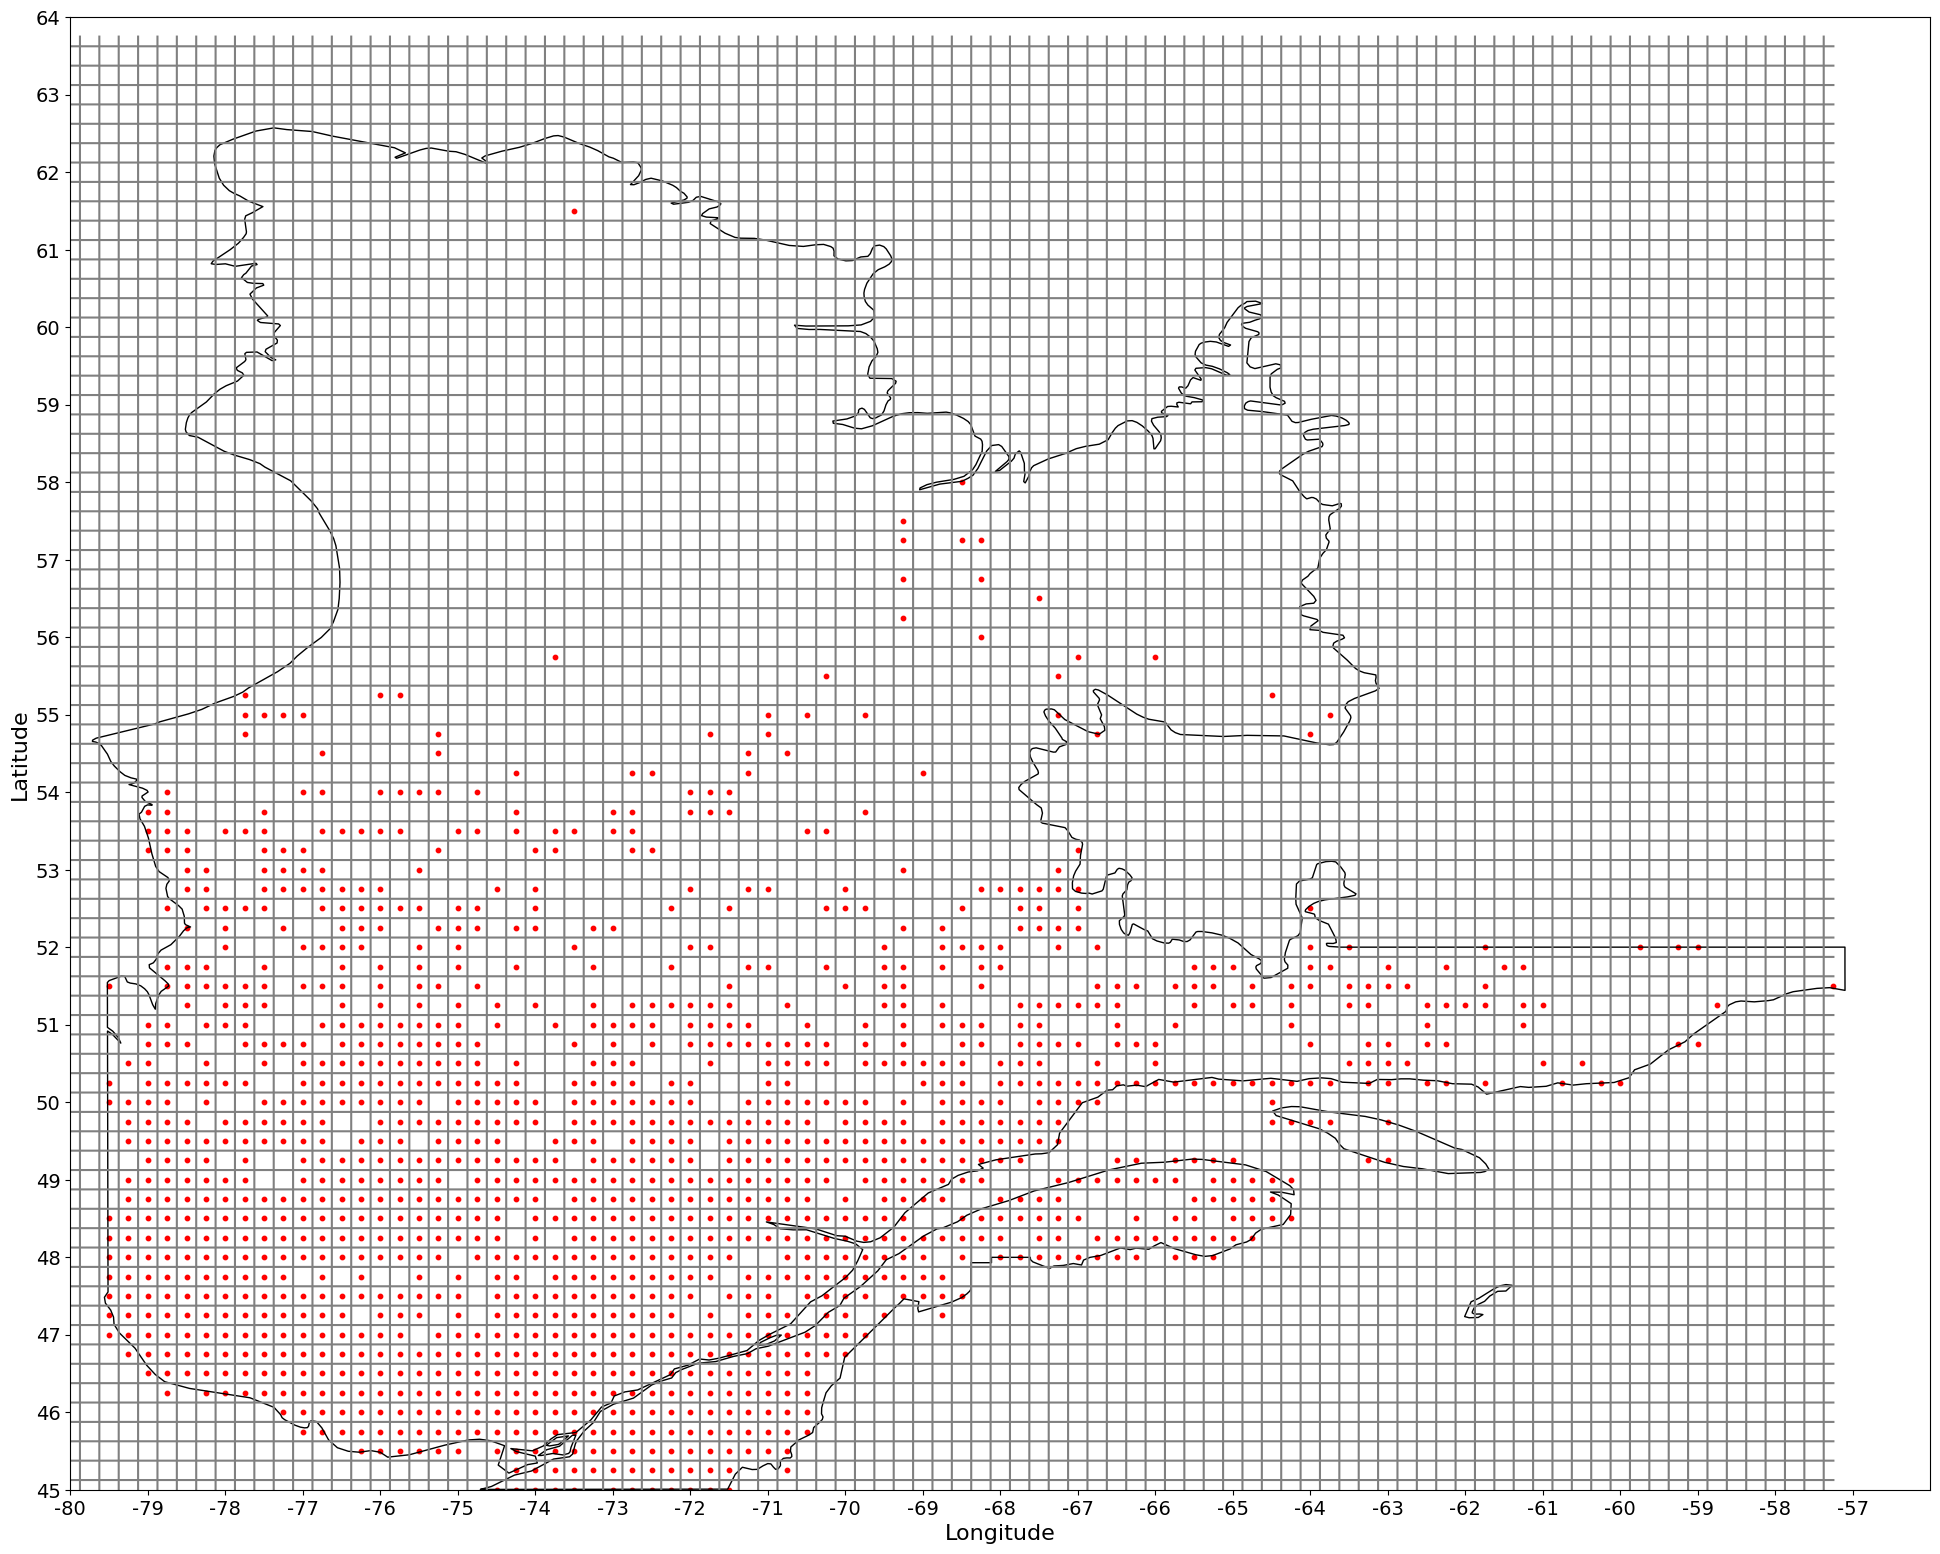

In [2]:
import geopandas as gpd
from data.view.plot_map import *
url = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces.zip"
canada = gpd.read_file(url)

# Filter for only québec
quebec = canada[canada["name"] == "Québec"]
fire_cells_coords = list(fire_cells[['CELL_LON', 'CELL_LAT']].itertuples(index=False, name=None))
fig,ax = plot_qc_map(quebec)
for lon, lat in fire_cells_coords:
    ax.scatter(lon, lat, color='red', s=10)
plt.show()

In [3]:
dataset_fire_path = os.path.join(current_dir, '..', 'storage', 'dataset',"dataset_fire_cleaned.csv")
df_fire = pd.read_csv(dataset_fire_path)
# Convert into float
df_fire["LONGITUDE"] = pd.to_numeric(df_fire["LONGITUDE"], errors='coerce')
df_fire["LATITUDE"] = pd.to_numeric(df_fire["LATITUDE"], errors='coerce')

# filter the data
filtered_df = df_fire[(df_fire["LONGITUDE"] >= -79.5) & (df_fire["LONGITUDE"] <= -64) &
                 (df_fire["LATITUDE"] >= 45.25) & (df_fire["LATITUDE"] <= 52)]

# Count the results
count = len(filtered_df)
countfull = len(df_fire)
print(f"{round(count/countfull*100,2)}% of fires are contained -79.5 and -58.75 and the latitudes 45.25 and 52")

91.84% of fires are contained -79.5 and -58.75 and the latitudes 45.25 and 52


#### As 91.84% of wildfires are contained -79.5 and -58.75 and the latitudes 45.25 and 52, so we will restrict our dataset to theses latitudes and longitudes, we also have to recalculate the coordinates since we changed the coordinate system.

In [4]:
filtered_dataset = dataset[(dataset["CELL_LON"] >= -79.5) & (dataset["CELL_LON"] <= -64) &
                 (dataset["CELL_LAT"] >= 45.25) & (dataset["CELL_LAT"] <= 52)]
filtered_dataset[["COORDINATES_LAT","COORDINATES_LON" ]] = ((filtered_dataset[["CELL_LAT", "CELL_LON"]]
                                                            - [45.25,-79.5]) / [0.25,0.25]).astype(int)

#### We will now plot the area we are focusing on, it is the one contained in the green rectangle.

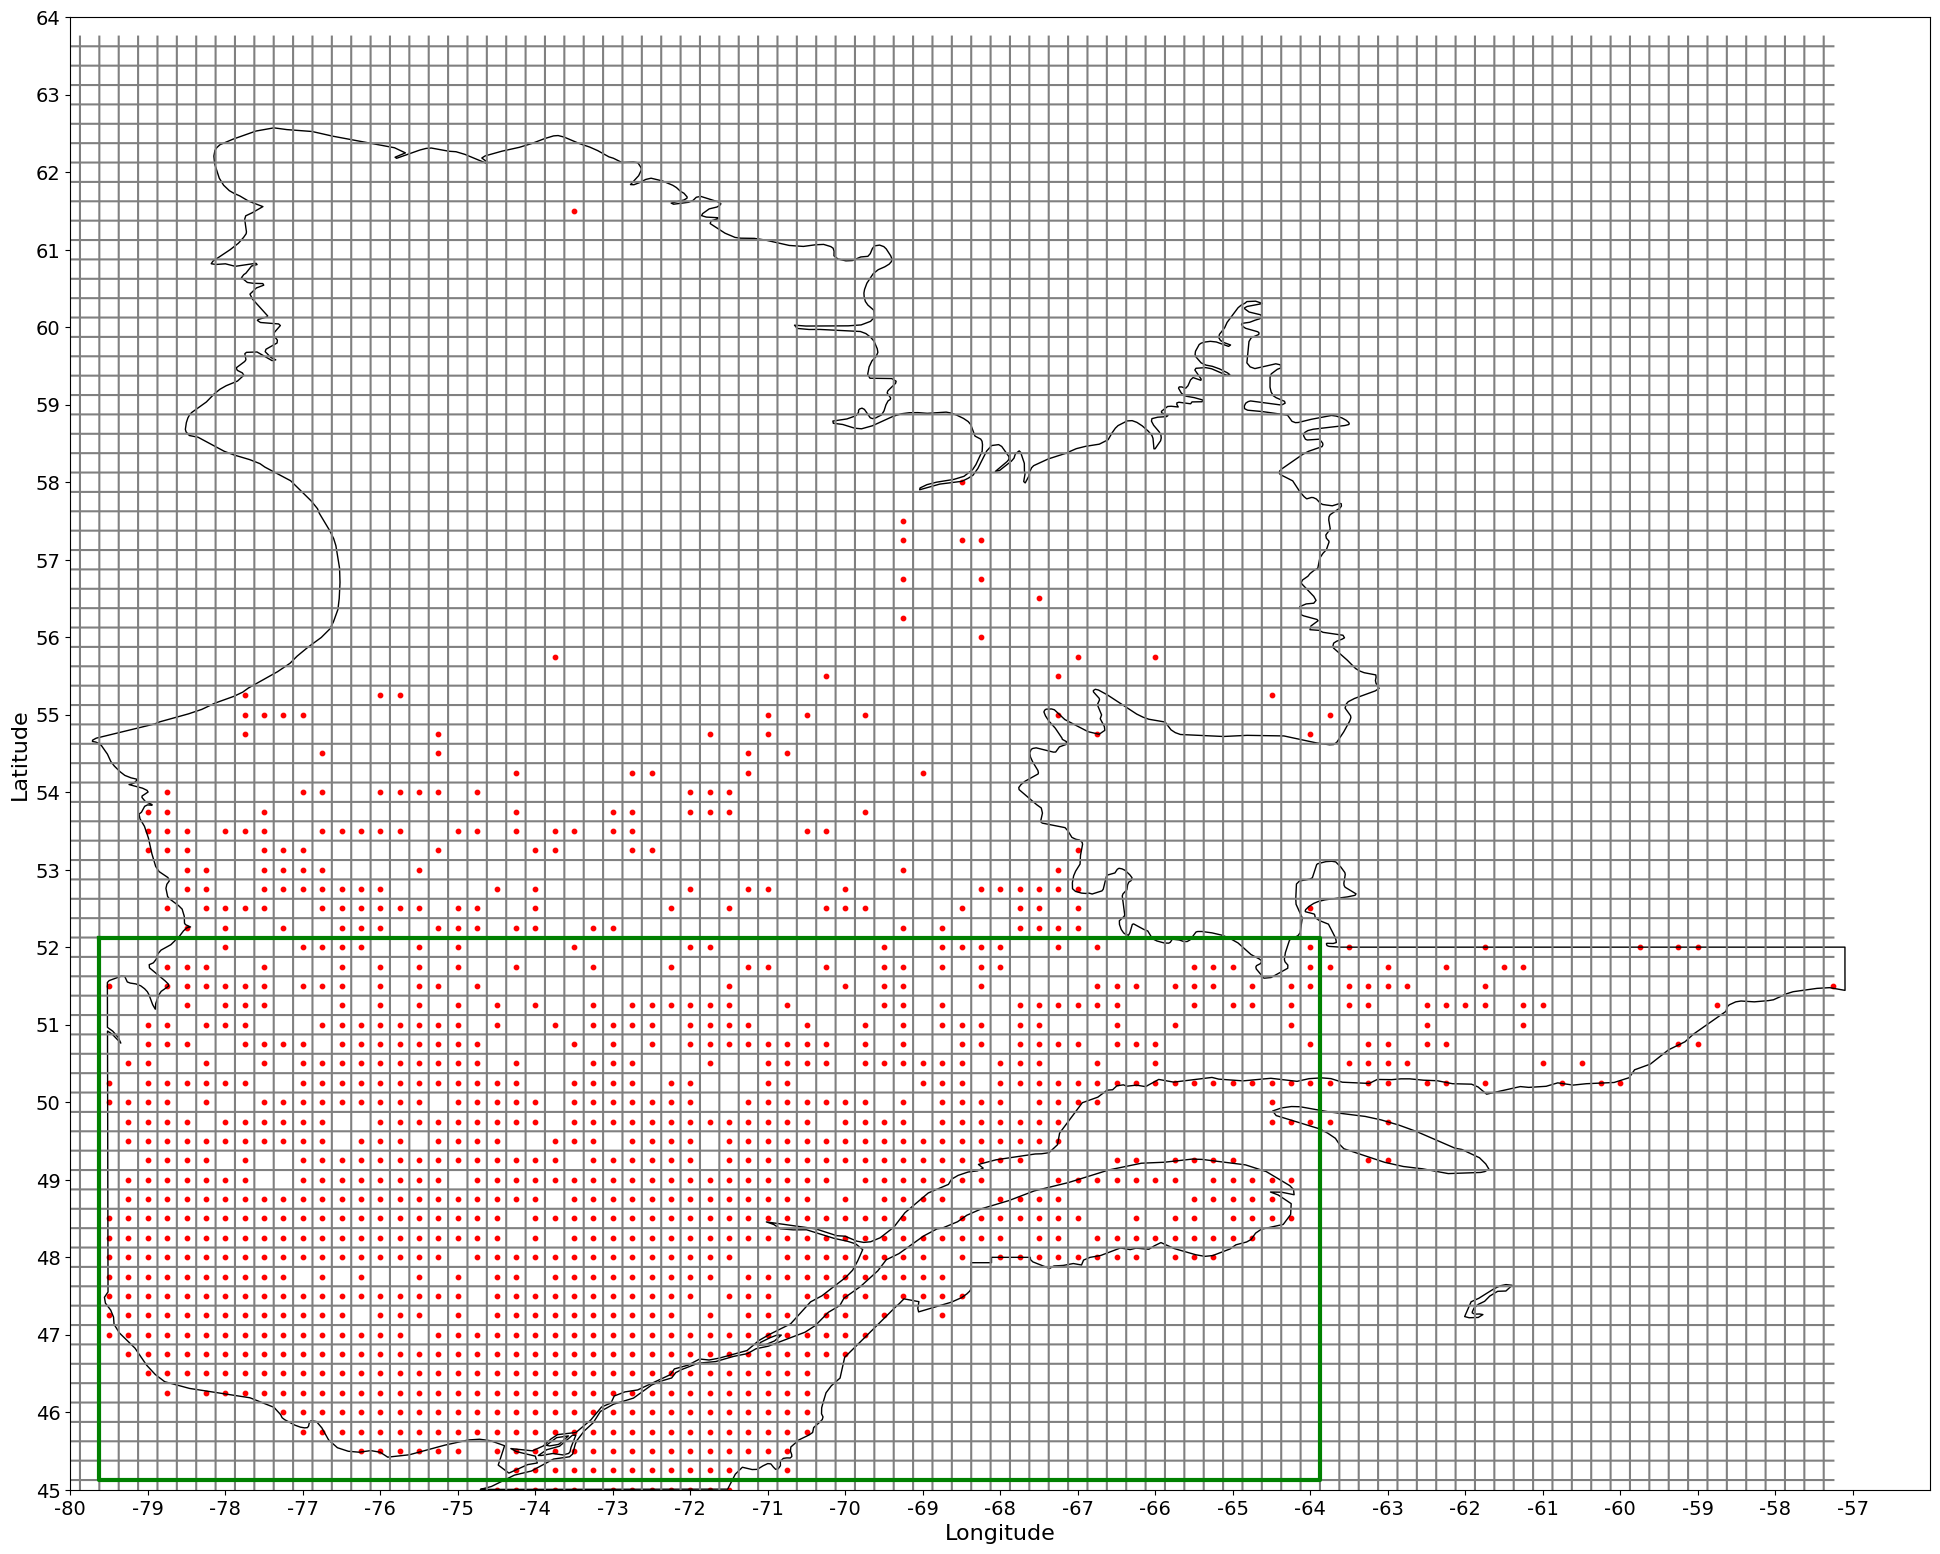

In [5]:
from data.view.plot_map import *
fire_cells_coords = list(fire_cells[['CELL_LON', 'CELL_LAT']].itertuples(index=False, name=None))
fig,ax = plot_qc_map(quebec)
for lon, lat in fire_cells_coords:
    ax.scatter(lon, lat, color='red', s=10)
ax.plot([-79.625,-79.625,-63.875,-63.875,-79.625],[52.125,45.125,45.125,52.125,52.125],color='green',linestyle='-',linewidth=3)
plt.show()

#### We will now erase the datapoints that are in the ocean.

In [6]:
from data.view.pixel_label import *

In [7]:
date = '2019-08-01'
filtered_dataset_date = filtered_dataset[filtered_dataset['DATE'] == date]
# Filtering the data with a date gives us a map
filtered_dataset_date['IN_OCEAN'] = filtered_dataset_date.apply(lambda row: is_cell_in_ocean(row['CELL_LAT'], row['CELL_LON'], ocean_gdf), axis=1)


# extract point that are in the ocean
points_in_ocean = filtered_dataset_date[filtered_dataset_date['IN_OCEAN']]

# extract the list of points in the ocean
lat_lon_list_ocean = points_in_ocean[['CELL_LAT', 'CELL_LON']].values.tolist()
lat_lon_set_ocean = set(map(tuple, lat_lon_list_ocean))

# erase the row that correponds to points in the ocean for every dates
filtered_dataset_no_ocean = filtered_dataset[~filtered_dataset[['CELL_LAT', 'CELL_LON']].apply(tuple, axis=1).isin(lat_lon_set_ocean)]


#### Let's see which points contained in the green rectangle are in the ocean. They are ploted in the map as the blue points.

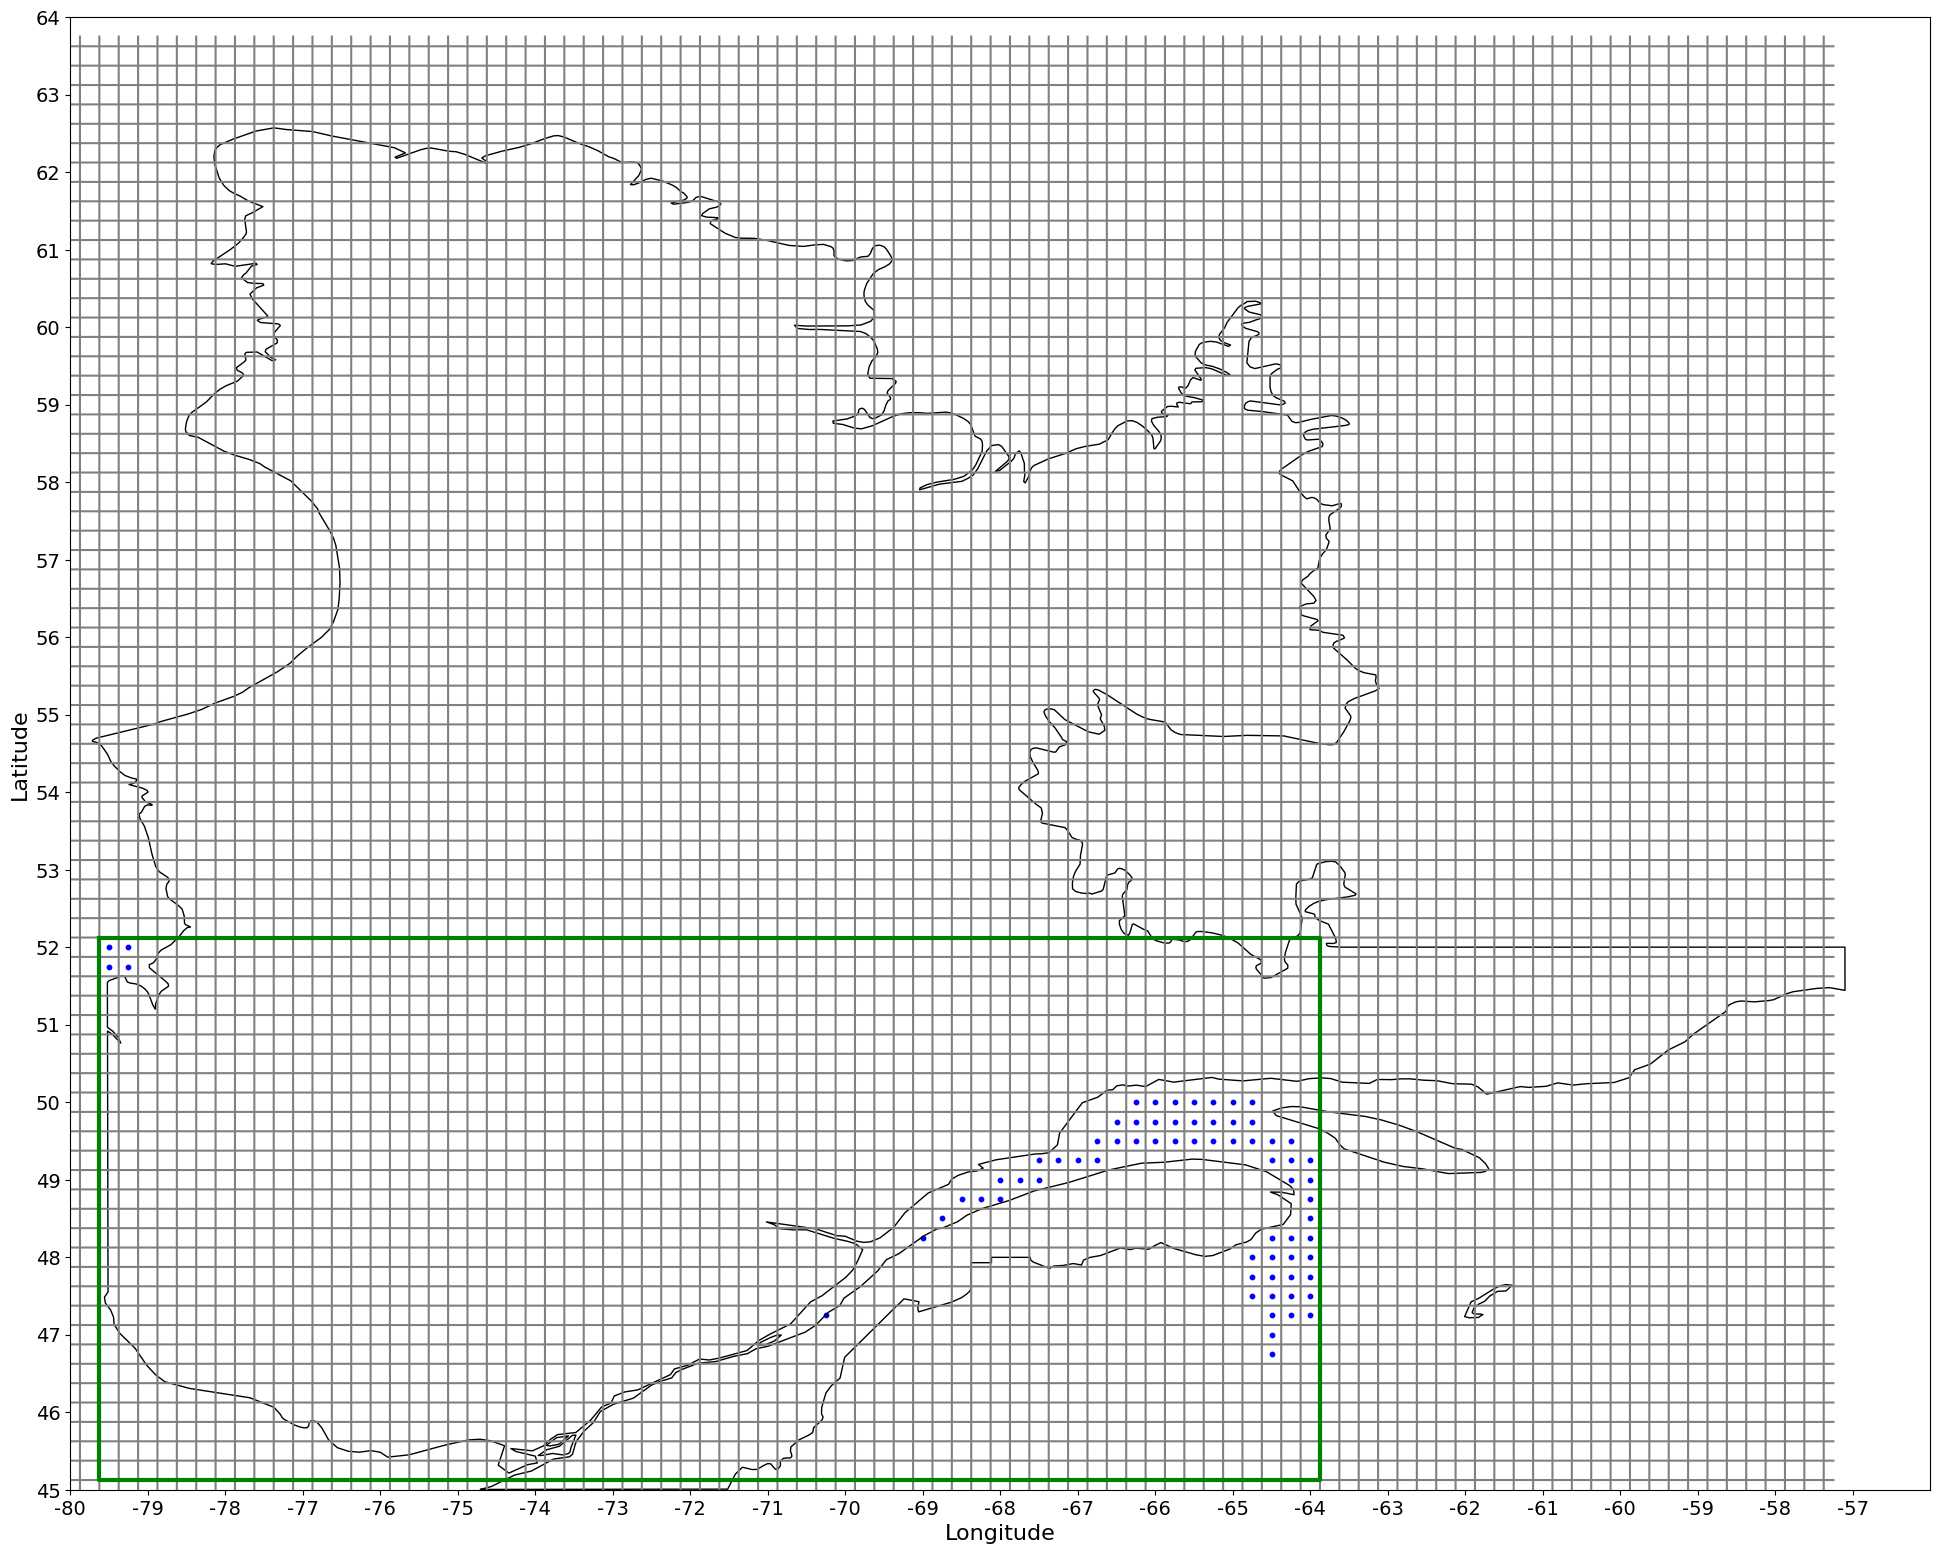

In [9]:
from data.view.plot_map import *
fire_cells_coords = list(fire_cells[['CELL_LON', 'CELL_LAT']].itertuples(index=False, name=None))
fig,ax = plot_qc_map(quebec)
for coo in lat_lon_list_ocean :
    ax.scatter(coo[1], coo[0], color='blue', s=10)
ax.plot([-79.625,-79.625,-63.875,-63.875,-79.625],[52.125,45.125,45.125,52.125,52.125],color='green',linestyle='-',linewidth=3)
plt.show()

#### We will now erase the datapoints that aren't in Québec.

In [10]:
date = '2019-08-01'
filtered_dataset_no_ocean_date = filtered_dataset_no_ocean[filtered_dataset_no_ocean['DATE'] == date]
# Filtering the data with a date gives us a map
filtered_dataset_no_ocean_date['IN_QC'] = filtered_dataset_no_ocean_date.apply(lambda row: is_cell_in_quebec(row['CELL_LAT'], row['CELL_LON'], quebec), axis=1)


# extract the point that are out of quebec
points_out_quebec = filtered_dataset_no_ocean_date[filtered_dataset_no_ocean_date['IN_QC']==False]

# extract the list of point that are out of quebec
lat_lon_list_notqc = points_out_quebec[['CELL_LAT', 'CELL_LON']].values.tolist()
lat_lon_set_notqc = set(map(tuple, lat_lon_list_notqc))

# erase the data point that are out of quebec for every date
filtered_dataset_no_ocean_qconly = filtered_dataset_no_ocean[~filtered_dataset_no_ocean[['CELL_LAT', 'CELL_LON']].apply(tuple, axis=1).isin(lat_lon_set_notqc)]


#### Let's see which points contained in the green rectangle are not in Québec. They are ploted in the map as the black points. Some may are not in other territory other than Québec, but they are in the ocean and we couldn't erase them with the previous functions, but we can do it now.

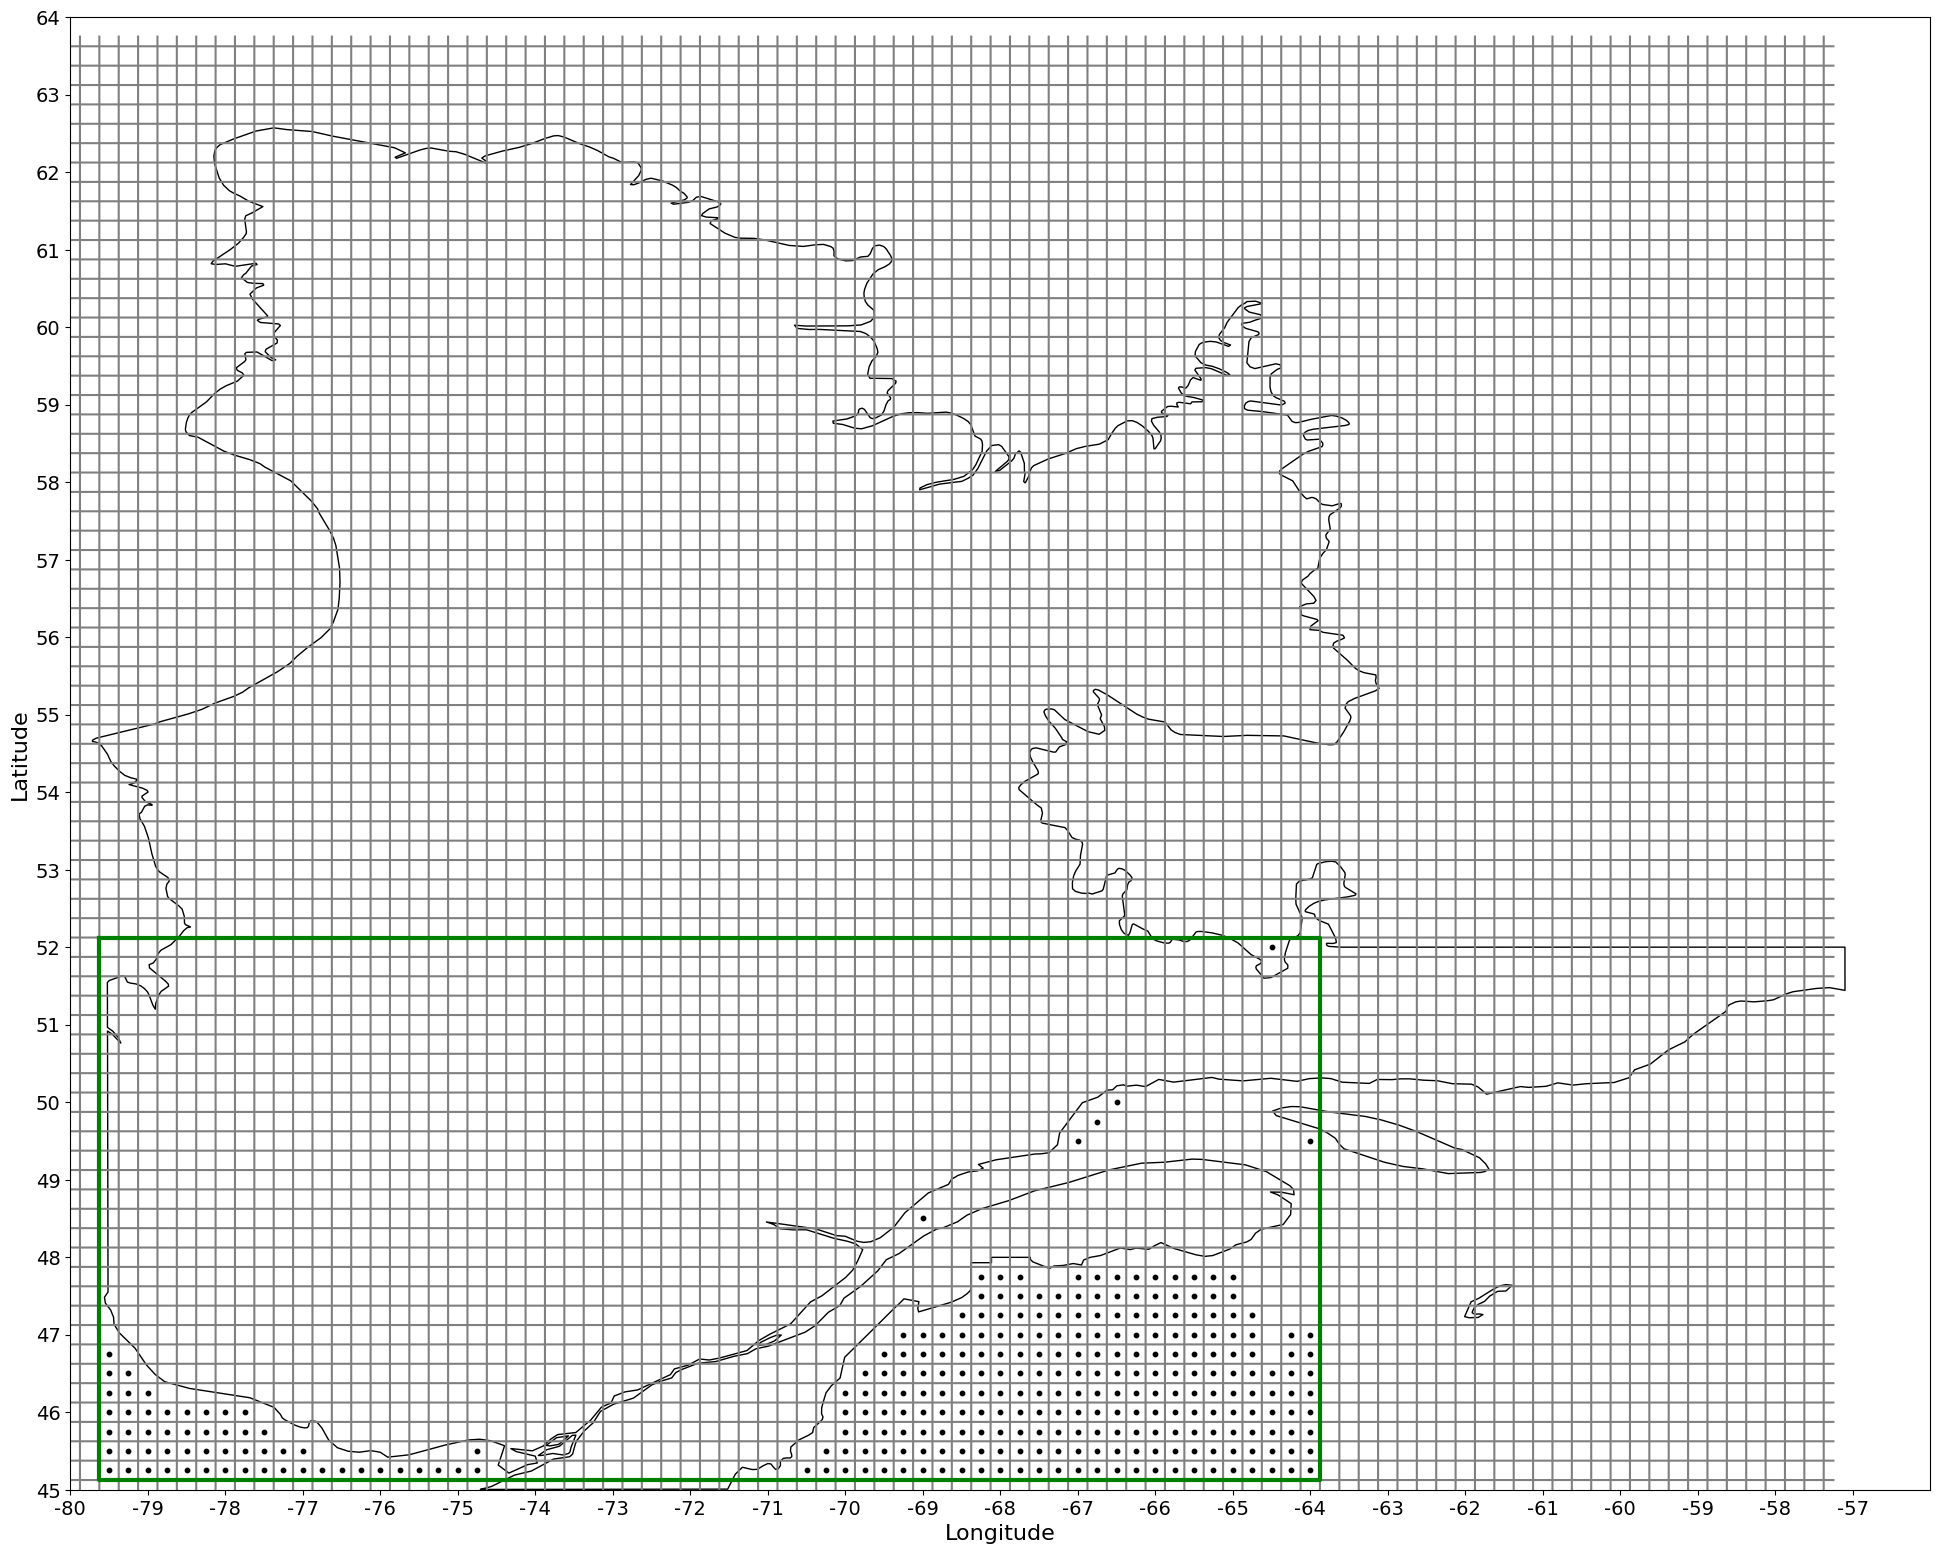

In [12]:
from data.view.plot_map import *
fire_cells_coords = list(fire_cells[['CELL_LON', 'CELL_LAT']].itertuples(index=False, name=None))
fig,ax = plot_qc_map(quebec)
for coo in lat_lon_list_notqc :
    ax.scatter(coo[1], coo[0], color='black', s=10)
ax.plot([-79.625,-79.625,-63.875,-63.875,-79.625],[52.125,45.125,45.125,52.125,52.125],color='green',linestyle='-',linewidth=3)
plt.show()

#### So in a nutshell now the dataset is are the cells contained in the green rectangle without the pixels that are within other territory than Québec and the ocean, so it is the following map with the orange pixels for each day between 2010 and 2021, without the blue and black ones. And then the geographical analysis will be finished.

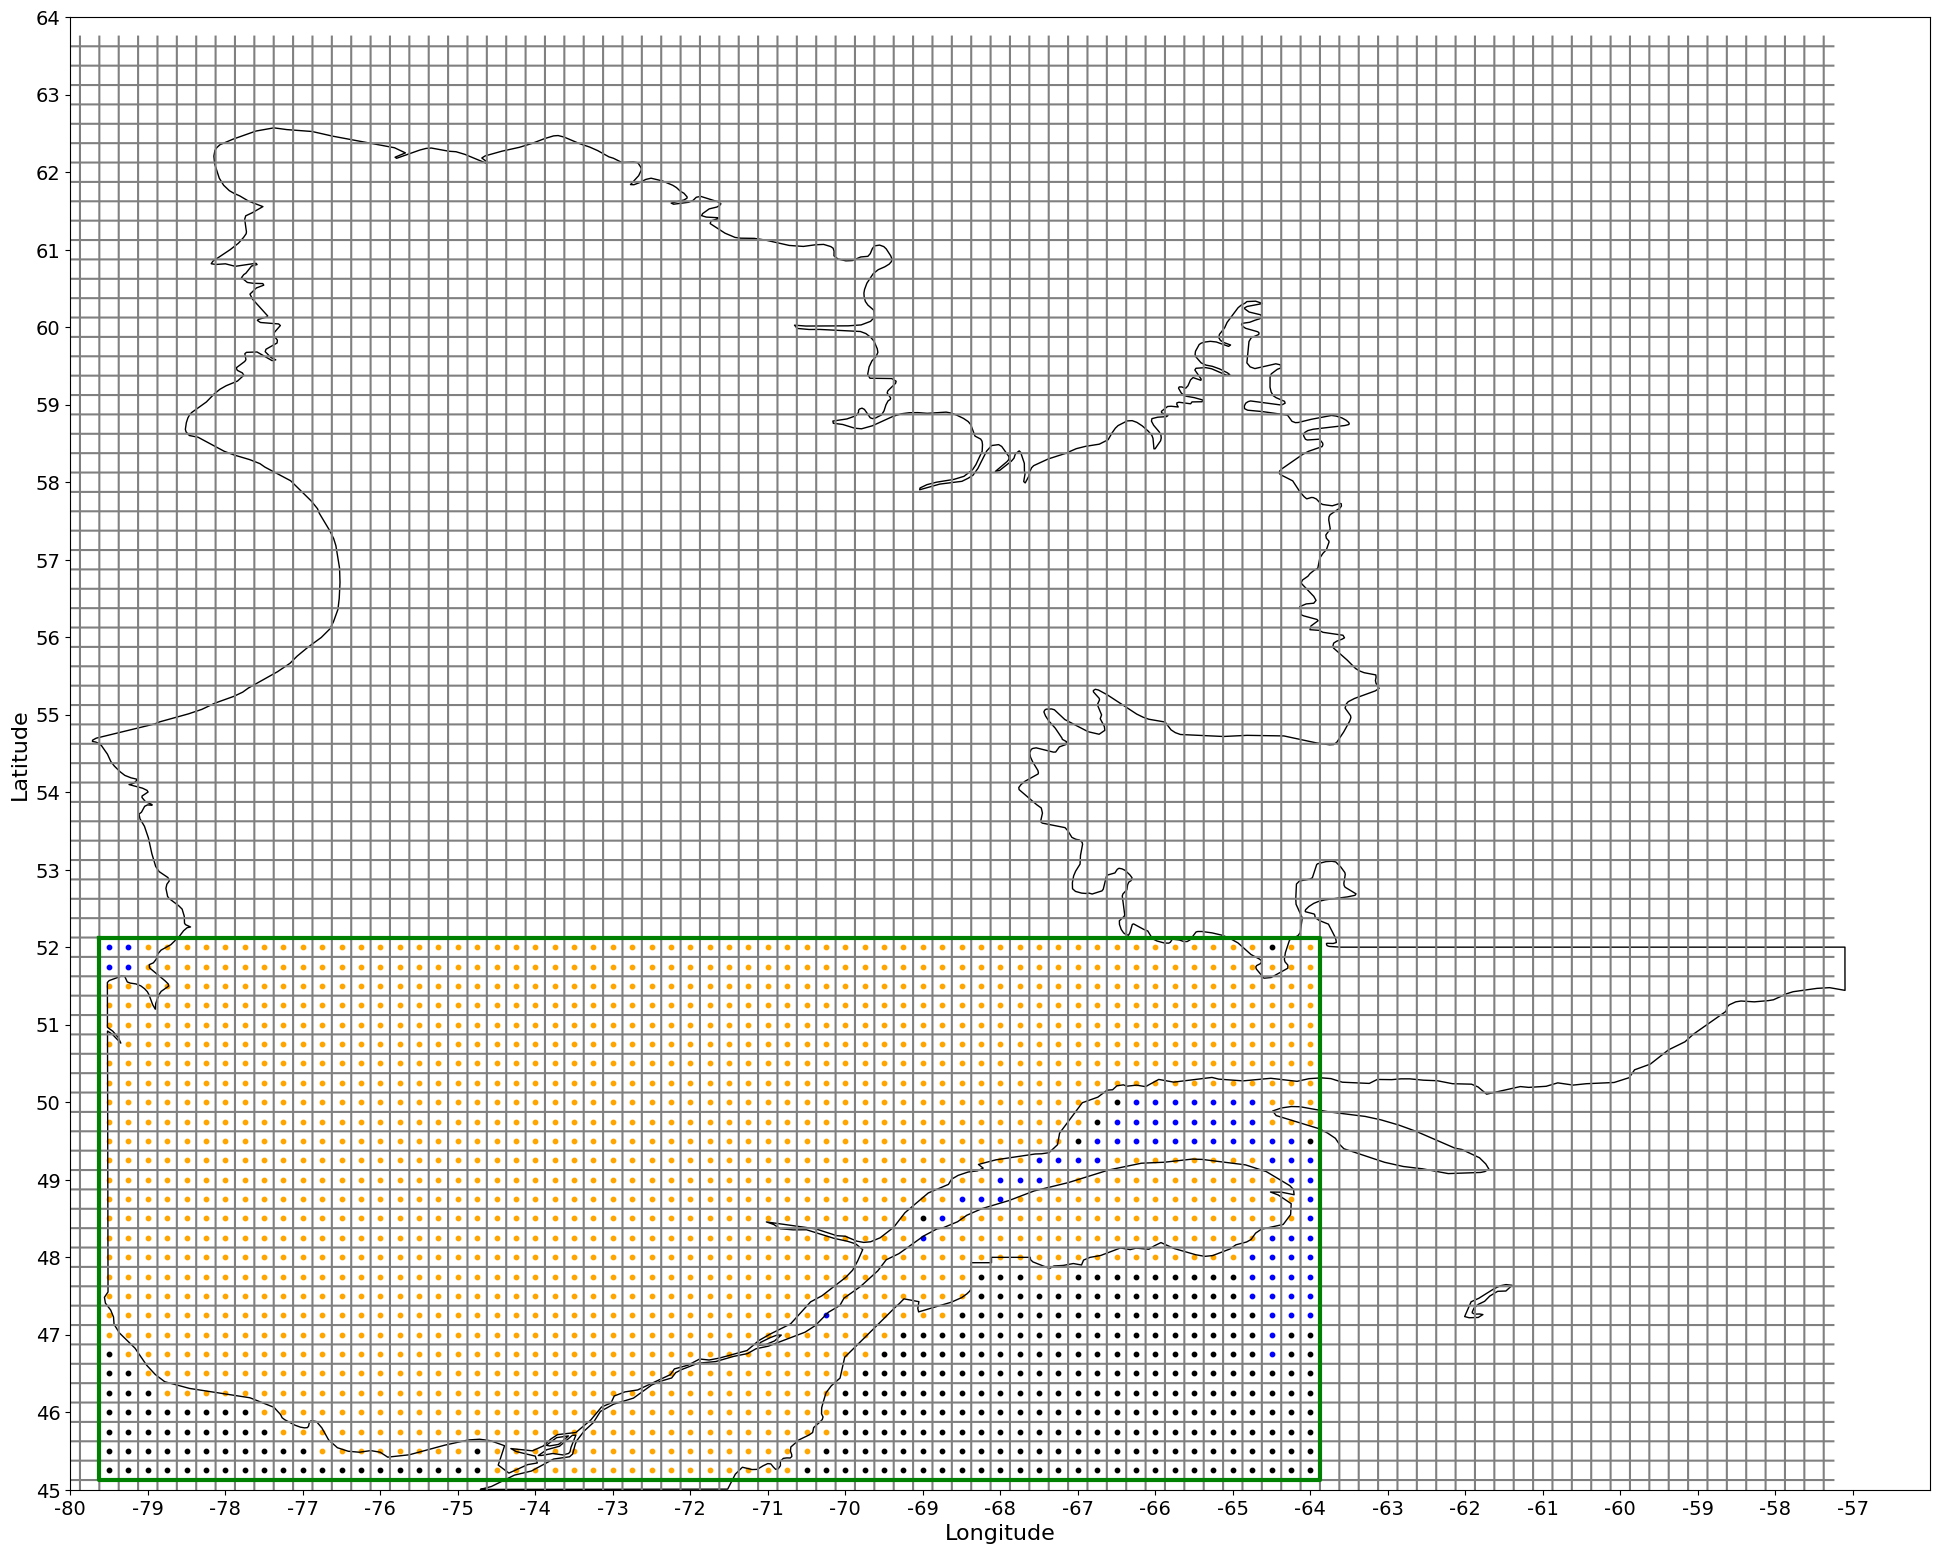

In [13]:
from data.view.plot_map import *
fire_cells_coords = list(fire_cells[['CELL_LON', 'CELL_LAT']].itertuples(index=False, name=None))
fig,ax = plot_qc_map(quebec)
for coo in lat_lon_list_notqc :
    ax.scatter(coo[1], coo[0], color='black', s=10)
ax.plot([-79.625,-79.625,-63.875,-63.875,-79.625],[52.125,45.125,45.125,52.125,52.125],color='green',linestyle='-',linewidth=3)
for coo in lat_lon_list_ocean :
    ax.scatter(coo[1], coo[0], color='blue', s=10)
filtered_dataset_no_ocean_qconly_date = filtered_dataset_no_ocean_qconly[filtered_dataset_no_ocean_qconly['DATE'] == date]
lat_lon_list= filtered_dataset_no_ocean_qconly_date[['CELL_LAT', 'CELL_LON']].values.tolist()
lat_lon_set = set(map(tuple, lat_lon_list))
for coo in lat_lon_set :
    ax.scatter(coo[1], coo[0], color='orange', s=10)
# plt.savefig('map.png')
plt.show()

#### We know naturraly that some time periods aren't concerned about forest fire, like the winter season for example. We will see for each year which period have no fire at all and erase it from the dataset.

In [14]:
df_filtered = df_fire[
    (df_fire["CELL_LON"] >= -79.5) & (df_fire["CELL_LON"] <= -64) &
    (df_fire["CELL_LAT"] >= 45.25) & (df_fire["CELL_LAT"] <= 52)
]

# convert the rep date for manipulation
df_filtered["REP_DATE"] = pd.to_datetime(df_filtered["REP_DATE"])

# extract year month and day
df_filtered["year"] = df_filtered["REP_DATE"].dt.year
df_filtered["month"] = df_filtered["REP_DATE"].dt.month
df_filtered["day"] = df_filtered["REP_DATE"].dt.day

# found earliest date of every year where there is a fire
earliest_per_year = df_filtered.groupby("year")["REP_DATE"].min()
latest_per_year = df_filtered.groupby("year")["REP_DATE"].max()

# we found the min and max for every year
earliest_month_day = earliest_per_year.dt.strftime('%m-%d').min()
latest_month_day = latest_per_year.dt.strftime('%m-%d').max()


print("Global earliest month-day:", earliest_month_day)
print("Global latest month-day:", latest_month_day)

Global earliest month-day: 03-11
Global latest month-day: 12-07


#### We see that before 11<sup>st</sup> March and after 7<sup>th</sup> December there is no fire at all, so we erase the period between the 7<sup>th</sup> December and 31<sup>st</sup> December, and the 1<sup>st</sup> January and 11<sup>st</sup> March.

In [15]:
import pandas as pd

# DATE to datetime
filtered_dataset_no_ocean_qconly["DATE"] = pd.to_datetime(filtered_dataset_no_ocean_qconly["DATE"], errors='coerce')

# filter 
mask_december_exclude = (filtered_dataset_no_ocean_qconly["DATE"].dt.month == 12) & (filtered_dataset_no_ocean_qconly["DATE"].dt.day > 7)

# filter
mask_jan_march_exclude = ((filtered_dataset_no_ocean_qconly["DATE"].dt.month == 1) | (filtered_dataset_no_ocean_qconly["DATE"].dt.month == 3)) & \
                          ((filtered_dataset_no_ocean_qconly["DATE"].dt.day >= 1) & (filtered_dataset_no_ocean_qconly["DATE"].dt.day <= 10))

# filter
mask_before_march_12 = (filtered_dataset_no_ocean_qconly["DATE"].dt.month == 1) | \
                        ((filtered_dataset_no_ocean_qconly["DATE"].dt.month == 2) & (filtered_dataset_no_ocean_qconly["DATE"].dt.day <= 28)) | \
                        ((filtered_dataset_no_ocean_qconly["DATE"].dt.month == 3) & (filtered_dataset_no_ocean_qconly["DATE"].dt.day <= 10))

# filter
filtered_data = filtered_dataset_no_ocean_qconly[~(mask_december_exclude | mask_jan_march_exclude | mask_before_march_12)]

In [16]:
filtered_data = filtered_data.sort_values(by=['CELL_LAT', 'CELL_LON', 'DATE'])

# add a column that indicates if the cell is on fire on the next day
filtered_data['IS_FIRE_NEXT_DAY'] = filtered_data.groupby(['CELL_LAT', 'CELL_LON'])['IS_FIRE'].shift(-1)

# replace NaN by 0
filtered_data['IS_FIRE_NEXT_DAY'] = filtered_data['IS_FIRE_NEXT_DAY'].fillna(0).astype(int)

dataset_analysis_path = os.path.join(current_dir, '..', 'storage', 'dataset',"dataset_end_analysis2.csv")
filtered_data = filtered_data.sort_values(by=['DATE','CELL_LAT', 'CELL_LON'])
filtered_data.to_csv(dataset_analysis_path, index=False)